# Исследование результатов A/A/B тестирования

## Информация о проекте

### Описание данных

**/datasets/logs_exp.csv**

- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


### План работы

- [x] 1) Подготовить данные:
      - Заменить названия столбцов;
      - Добавить столбец даты и времени, а также отдельный столбец дат;
      - Проверить пропуски и типы данных.
- [x] 2) Изучить и проверьте данные:
      - Узнать сколько всего событий в логе;
      - Узнать сколько всего пользователей в логе;
      - Узнать сколько в среднем событий приходится на пользователя;
      - Найти максимальную и минимальную дату, а также построить столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп;
      - На основе предыдущего шага определить, с какого момента данные полные и отбросить более старые;
      - Определить сколько событий и пользователей было утеряно в результате чистки данных;
      - Проверить, что во всех 3 исследуемых группах сохранились пользователи.
- [x] 3) Изучить воронку событий:
      - Посмотреть, какие события есть в логах, как часто они встречаются и отсортировать события по частоте;
      - Посчитать, сколько пользователей совершали каждое из этих событий. Отсортировать события по числу пользователей. Посчитать долю пользователей, которые хоть раз совершали событие;
      - Предположить, в каком порядке происходят события (Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки);
      - По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки;
      - Узнать, на каком шаге теряется больше всего пользователей;
      - Какая доля пользователей доходит от первого события до оплаты.
- [x] 4) Изучить результаты эксперимента:
      - Посчитать количество пользователей в каждой экспериментальной группе;
      - Проверить, находят ли статистические критерии разницу между выборками 246 и 247;
      - Выбрать самое популярное событие. Посчитать число пользователей, совершивших это событие в каждой из контрольных групп. Посчитать долю пользователей, совершивших это событие. Проверить, будет ли отличие между группами статистически достоверным. Сделать то же самое для всех других событий;
      - Аналогично поступить с группой с изменённым шрифтом. Сравнить результаты с каждой из контрольных групп в отдельности по каждому событию. Сравнить результаты с объединённой контрольной группой. Сделать выводы;
      - Посчитать, сколько проверок статистических гипотез было сделано. При уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна. Определить какой уровень значимости стоит применить. В случа необходимости заменить урвоень значимости и заново проделать предыдущие пункты и проверить выводы.



## Подготовка данных

### Загрузка библиотек и файла

In [1]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math as mth
import datetime as dt
from scipy import stats as st

pd.options.mode.chained_assignment = None

In [2]:
# Открываем файл и выводим общую информацию о нем
data = pd.read_csv('/datasets/logs_exp.csv', delimiter='\t')
data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


### Замена названий столбцов

In [3]:
# Заменяем названия столбцов 
data.columns = ['event_name','user_id','event_timestamp','exp_id']

### Добавление столбцов с датой и временем

In [4]:
# Создаем столбцы с датой и временем, а также отдельный только с датой
data['datetime'] = pd.to_datetime(data['event_timestamp'], unit='s')
data['date'] = data['datetime'].apply(lambda x: x.date()) # Не стал переводить к типу datetime64[ns], чтобы в дальнейшем дата\
# имела более приятный вид без нулей во времени

### Проверка пропусков и типов данных

In [5]:
# Смотрим наличие дубликатов значений в столбце event_name
data['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [6]:
# Смотрим наличие дубликатов значений в столбце exp_id
data['exp_id'].unique()

array([246, 248, 247])

In [7]:
# Смотрим наличие дубликатов строк в датафрейме
data[data.duplicated()]

,event_name,user_id,event_timestamp,exp_id,datetime,date
453,MainScreenAppear,5613408041324010552,1564474784,248,2019-07-30 08:19:44,2019-07-30
2350,CartScreenAppear,1694940645335807244,1564609899,248,2019-07-31 21:51:39,2019-07-31
3573,MainScreenAppear,434103746454591587,1564628377,248,2019-08-01 02:59:37,2019-08-01
4076,MainScreenAppear,3761373764179762633,1564631266,247,2019-08-01 03:47:46,2019-08-01
4803,MainScreenAppear,2835328739789306622,1564634641,248,2019-08-01 04:44:01,2019-08-01
...,...,...,...,...,...,...
242329,MainScreenAppear,8870358373313968633,1565206004,247,2019-08-07 19:26:44,2019-08-07
242332,PaymentScreenSuccessful,4718002964983105693,1565206005,247,2019-08-07 19:26:45,2019-08-07
242360,PaymentScreenSuccessful,2382591782303281935,1565206049,246,2019-08-07 19:27:29,2019-08-07
242362,CartScreenAppear,2382591782303281935,1565206049,246,2019-08-07 19:27:29,2019-08-07


In [8]:
# Удаляем дубликаты из датафрейма и обновляем индексы
data = data.drop_duplicates()
data = data.reset_index(drop=True)

In [9]:
# Ещё раз смотрим типы данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   user_id          243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  int64         
 4   datetime         243713 non-null  datetime64[ns]
 5   date             243713 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.2+ MB


<div class="alert alert-block alert-info">
    
<h3> Вывод  <a class="tocSkip"></h3>

Метод info() показал нам отсутствие пропусков данных. Типы данных в столбцах также соответствуют самим данным.
    
Проверка столбцов "event_name" и "exp_id" на дубликаты значений ничего не показала. При проверки дубликатов строк было выявлено 413 дубликатов. В виду того, что столбец "event_timestamp" содержит в себе время вплоть до долей секунд, обнаруженные дубликаты с высокой вероятностью таковыми и являются, поэтому было решено их удалить. 
    
</div>

## Изучение и проверка данных

### Определение количества событий, пользователей и среднего количества событий на пользователя в логе

In [10]:
# Смотрим количество событий в логе
print('Количество событий в логе:', len(data['event_name']))

# Смотрим количество пользователей в логе
print('Количество уникальных пользователей в логе:', len(data['user_id'].unique()))

# Определяем среднее количество событий на одного пользователя
users_events = data.pivot_table(index='user_id', values='event_name', aggfunc='count')
print('Среднее количество событий на одного уникального пользователя:', round(users_events['event_name'].mean()))

Количество событий в логе: 243713
Количество уникальных пользователей в логе: 7551
Среднее количество событий на одного уникального пользователя: 32


### Определение сроков проведения тестирования

In [11]:
# Определяем минимальную дату
print('Минимальная дата:', data['date'].min())
# Определяем максимальную дату
print('максимальная дата:', data['date'].max())


Минимальная дата: 2019-07-25
максимальная дата: 2019-08-07


### Построение диаграмм с количеством событий по дням

In [12]:
# Создаём общую сводную таблицу событий по дням
total_events = data.pivot_table(index='date', values='event_name', aggfunc='count')
total_events.columns = ['event_count']

# Создаём сводную таблицу событий по дням для группы 246
events_246 = data[data['exp_id'] == 246].pivot_table(index='date', values='event_name', aggfunc='count')
events_246.columns = ['event_count']

# Создаём сводную таблицу событий по дням для группы 247
events_247 = data[data['exp_id'] == 247].pivot_table(index='date', values='event_name', aggfunc='count')
events_247.columns = ['event_count']

# Создаём сводную таблицу событий по дням для группы 248
events_248 = data[data['exp_id'] == 248].pivot_table(index='date', values='event_name', aggfunc='count')
events_248.columns = ['event_count']

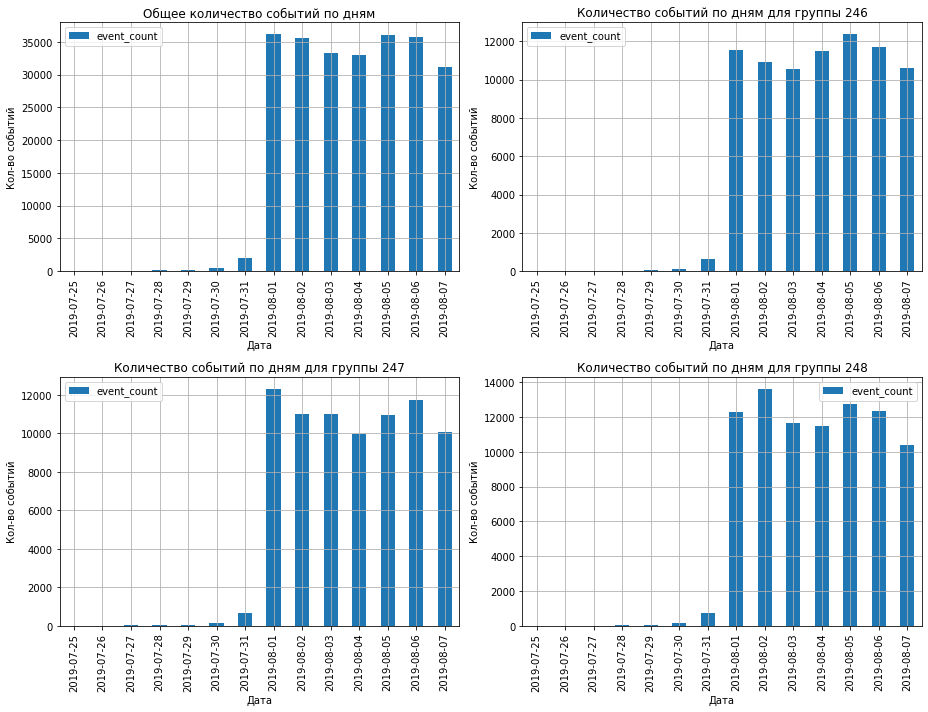

In [13]:
# Выводим графики количеста событий по дням на основе созданных сводных таблиц
plt.figure(figsize = (13, 10))

total_events.plot(y='event_count',
                   kind='bar', grid=True, 
                   title=('Общее количество событий по дням'), 
                   xlabel=('Дата'), 
                   ylabel=('Кол-во событий'),
                   ax=plt.subplot(2, 2, 1)
                  )
events_246.plot(y='event_count',
                   kind='bar', grid=True, 
                   title=('Количество событий по дням для группы 246'), 
                   xlabel=('Дата'), 
                   ylabel=('Кол-во событий'),
                   ax=plt.subplot(2, 2, 2)
                  )
events_247.plot(y='event_count',
                   kind='bar', grid=True, 
                   title=('Количество событий по дням для группы 247'), 
                   xlabel=('Дата'), 
                   ylabel=('Кол-во событий'),
                   ax=plt.subplot(2, 2, 3)
                  )
events_248.plot(y='event_count',
                   kind='bar', grid=True, 
                   title=('Количество событий по дням для группы 248'), 
                   xlabel=('Дата'), 
                   ylabel=('Кол-во событий'),
                   ax=plt.subplot(2, 2, 4)
                  )
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
    
<h3> Комментарий  <a class="tocSkip"></h3>

Как мы можем увидеть на графиках, во всех группах основная часть событий произошла с 1 по 7 августа. Лучше будет сфокусироваться на этом временном отрезке и убрать данные, которые в него не входят, с целью проведения более "чистого" анализа. 
</div>

### Очистка данных и изучение их последующих изменений

In [16]:
# Создаем таблицу с "очищенными" данными
clean_data = data[data['datetime'] >= '2019-8-1']
clean_data = clean_data.reset_index()

In [17]:
# Смотрим, сколько данных у нас осталось
print(f'По итогу чистки данных мы потеряли {round((1-len(clean_data)/len(data))*100)}% данных')

По итогу чистки данных мы потеряли 1% данных


In [18]:
# Создаем переменную для количества уникальных пользователей в data
data_uniq_user = data['user_id'].nunique()

# Создаем переменную для количества уникальных пользователей в clean_data
clean_data_uniq_user = clean_data['user_id'].nunique()

users_difference = data_uniq_user-clean_data_uniq_user
users_percent = round(100-(clean_data_uniq_user/data_uniq_user)*100,2)

# Смотрим, сколько уникальных пользователей мы потеряли
print(f'По итогу очистки данных мы потеряли {users_difference} или же {users_percent}% уникальных пользователей')

По итогу очистки данных мы потеряли 17 или же 0.23% уникальных пользователей


In [19]:
# Смотрим количество событий в очищенном логе
print('Количество событий в логе:', len(clean_data['event_name']))

# Смотрим количество пользователей в очищенном логе
print('Количество уникальных пользователей в логе:', len(clean_data['user_id'].unique()))

# Определяем среднее количество событий на одного пользователя в очищенном логе
clean_users_events = clean_data.pivot_table(index='user_id', values='event_name', aggfunc='count')
print('Среднее количество событий на одного уникального пользователя:', round(clean_users_events['event_name'].mean()))

Количество событий в логе: 240887
Количество уникальных пользователей в логе: 7534
Среднее количество событий на одного уникального пользователя: 32


In [20]:
# Выполняем проверку наличия пользователей из всех групп по условию задания
clean_data.pivot_table(index='exp_id', values='event_name', aggfunc='count')

,event_name
exp_id,
246,79302
247,77022
248,84563


<div class="alert alert-block alert-info">
    
<h3> Вывод  <a class="tocSkip"></h3>

После изучения и проверки данных мы выяснили, что:
- Общее количество событий в логе равняется 243 713;
- Количество уникальных пользователей в логе составляет 7 551;
- Среднее количество событий на пользователя - 32;
- В логе собранны за период с 2019-07-25 по 2019-08-07;
- При этом данные до 2019-08-01 являются неполными, в следствие чего мы отсеяли их, создав датафрейм clean_data с событиями за август. По итогу очистки у нас осталось 99% данных.
    
После очистки данных у нас осталось: 
- Количество событий в логе равняется 240 887;
- Количество уникальных пользователей в логе составляет 7 534;
- Среднее количество событий на одного уникального пользователя - 32.
    
По итогу очистки данных мы потеряли 17 или же 0.23% уникальных пользователей
    
Как мы можем увидеть, по итогам очистки незначительно уменьшилось количество событий и уникальных пользователей. Среднее количество событий на одного пользователя осталось тем же.
</div>

## Изучение воронки событий

### Просмотр событий лога

In [21]:
# Создаем сводную для определения событий воронки и того, как часто они всречаются 
events = (clean_data.pivot_table(index='event_name', values='user_id', aggfunc='count')
                    .sort_values(by='user_id', ascending = False)
         )
events.columns = ['events_total']
events

,events_total
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


### Исследование данных пользователей по событиям

In [22]:
# Создаем сводную по кол-ву уникальных пользователей для каждого события с сортировкой по убыванию
users_by_events = (clean_data.groupby('event_name')['user_id']
                             .nunique()
                             .reset_index()
                             .sort_values(by='user_id', ascending = False)
                             .reset_index(drop=True)
                  )
users_by_events.columns = ['event_name', 'unique_users']

# Создаем столбец с подсчетом доли пользователей на событие от их общего числа
users_by_events['users_proportion'] = round(users_by_events['unique_users']/7534, 2)
users_by_events

,event_name,unique_users,users_proportion
0,MainScreenAppear,7419,0.98
1,OffersScreenAppear,4593,0.61
2,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47
4,Tutorial,840,0.11


<div class="alert alert-block alert-info">
    
<h3> Комментарий  <a class="tocSkip"></h3>

Как мы можем увидеть, доля пользователей, посетивших главное меню, равняется 98%. Это означает, что данный шаг не является первым. Разумно предположить, что шаг с обучением является первым шагом воронки, но если учитывать тот факт, что у данного шага самая маленькая доля посещения среди всех остальных шагов (11%), то можно предположить, что он является не только первым, но и необязательным. Выходит, что именно на данном этапе и пропали те самые 2%, которых не хватает на этапе главного меню.\
    Остальные этапы воронки идут в том же порядке событий по убыванию без изменения.
</div>

### Построение и исследование возможной посследовательности событий воронки без учета необязательных шагов

In [23]:
# Уберём шаг с обучением для дальнейшего подсчета воронки
users_by_events = users_by_events[users_by_events['event_name'] != 'Tutorial']
users_by_events

# Добавим строку с общим количеством пользователей, чтобы отобразить в таблице отскок пользователей, недошедших до меню
users_by_events.loc[-1] = ['TotalUsers', 7534, 1]
users_by_events.index = users_by_events.index + 1
users_by_events = users_by_events.sort_index()

In [24]:
# Создаем столбец с количеством пользователей прошлого этапа
users_by_events['previous_users'] = users_by_events['unique_users'].shift(1)

# Считаем долю пользователей, прошедших на следующий этап
users_by_events['passed_users_proportion'] = round(users_by_events['unique_users']/users_by_events['previous_users'],2)

# Заполняем пропуски и удаляем столбец с количеством пользователей на прошлом этапе
users_by_events = users_by_events.fillna(0)
users_by_events = users_by_events.drop('previous_users', axis=1)

users_by_events

,event_name,unique_users,users_proportion,passed_users_proportion
0,TotalUsers,7534,1.00,0.00
1,MainScreenAppear,7419,0.98,0.98
2,OffersScreenAppear,4593,0.61,0.62
3,CartScreenAppear,3734,0.50,0.81
4,PaymentScreenSuccessful,3539,0.47,0.95


<div class="alert alert-block alert-info">
    
<h3> Вывод  <a class="tocSkip"></h3>

Согласно полученным данным, наибольший отскок пользователей между этапами происходит на шаге возникновения экрана предложения. Всего 62% пользователей доходит до данного этапа после посещения главного меню.\
До момента оплаты доходит 47% от всех пользователей и 95% пользователей, открывших корзину, что можно оценить как хороший показатель.
</div>

## Изучение результатов эксперимента

### Определение количества уникальных пользователей в экспериментальных группах

In [25]:
# Выводим сводную таблицу с количеством пользователей в каждой экспериментальной группе
# Напомним, 246 и 247 — контрольные группы, а 248 — экспериментальная.
clean_data.pivot_table(index='exp_id', values='user_id', aggfunc='nunique')

,user_id
exp_id,
246,2484
247,2513
248,2537


In [26]:
# Проверяем, есть ли пользователи, которые входят сразу в несколько групп
user_group_counts = clean_data.groupby('user_id')['exp_id'].nunique()
multiple_group_users = user_group_counts[user_group_counts > 1]
multiple_group_users

Series([], Name: exp_id, dtype: int64)

<div class="alert alert-block alert-info">
    
<h3> Комментарий  <a class="tocSkip"></h3>
 
Каждая группа содержит уникальных пользователей
</div>

### Проверка разницы долей между выборками 246 и 247

In [27]:
# Создаем сводную таблицу, по которой можно отследить для каждого события кол-во уникальных пользователей в каждой из групп
events_exp = clean_data.pivot_table(index='event_name', values= 'user_id', columns='exp_id', aggfunc='nunique')
events_exp.columns = ['exp_246', 'exp_247', 'exp_248']
events_exp = events_exp.sort_values(by='exp_246', ascending=False).reset_index()

# Добавим строку с общим количеством пользователей в начало датафрейма
events_exp.loc[-1] = ['TotalUsers', 2484, 2513, 2537]
events_exp.index = events_exp.index + 1
events_exp = events_exp.sort_index()

# Убираем шаг с обучением
events_exp = events_exp[events_exp['event_name'] != 'Tutorial']

events_exp

,event_name,exp_246,exp_247,exp_248
0,TotalUsers,2484,2513,2537
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
3,CartScreenAppear,1266,1238,1230
4,PaymentScreenSuccessful,1200,1158,1181


<div class="alert alert-block alert-info">
    
<h3> Проверка гипотезы  <a class="tocSkip"></h3>

Уровень значимости (a) = 0.05\
Выбранный тест: Z-тест для пропорций
    
Гипотеза:    
H0 Доли между контрольными группами на этапе "PaymentScreenSuccessful" не различаются.\
H1 Доли между контрольными группами на этапе "PaymentScreenSuccessful" различаются.
</div>

In [28]:
# Создаем функцию для определения наличия разницы между экспериментальными выборками
def check_proportions(total, event, exp_1, exp_2, alpha=0.05):
    
    cohort_1 = events_exp.loc[events_exp['event_name'] == total, exp_1].values[0]
    cohort_2 = events_exp.loc[events_exp['event_name'] == total, exp_2].values[0]
    event_1 = events_exp.loc[events_exp['event_name'] == event, exp_1].values[0]
    event_2 = events_exp.loc[events_exp['event_name'] == event, exp_2].values[0]
    
    p1 = event_1/cohort_1
    p2 = event_2/cohort_2
    
    p_combined = (event_1+event_2)/(cohort_1+cohort_2)
    
    difference = p1 - p2
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/cohort_1 + 1/cohort_2))
    
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [29]:
# Используем функцию для определения различий в конверсии между контрольными группами
check_proportions('TotalUsers', 'PaymentScreenSuccessful', 'exp_246', 'exp_247', alpha=0.05)

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<div class="alert alert-block alert-info">
    
<h3> Вывод  <a class="tocSkip"></h3>
Проверка гипотезы показала, что мы не можем сделать вывод о различии в конверсии контрольных групп
    
</div>

### Изучение долей пользователей для каждого из событий по группам

In [30]:
# Выводим таблицу с информацией о том, сколько раз произошло каждое событие
events
# Наиболее популярным событием является появление экрана меню, с ним для начала и будем работать

,events_total
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


In [31]:
# Выводим сводную таблицу с количеством пользователей для каждого события
events_exp

,event_name,exp_246,exp_247,exp_248
0,TotalUsers,2484,2513,2537
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
3,CartScreenAppear,1266,1238,1230
4,PaymentScreenSuccessful,1200,1158,1181


<div class="alert alert-block alert-info">
    
<h3> Комментарий  <a class="tocSkip"></h3>

Как мы можем увидеть, каждое событие совершило, примерно, одинаковое количество пользователей в каждой из исследуемых групп, но есть небольшие рассхождения. Так, например, главное меню посетило больше всего пользователей из 248 группы, но их число лишь на 43 человека больше чем у 246 группы с минимальным показателем по данному событию. При это уже на следующем шаге "предложений" количество пользователей больше всего у 246 группы (1542 человека), а наименьше у 247 (1520 человек). Это говорит нам о том, что нет явного доминирования у одной из исследуемых групп. Их показатели, примерно, равны, и нужно дальше продолжать исследование.
    
</div>

In [32]:
# Добавляем в датафрейм events_exp столбцы с долей пользователей, дошедших до события

events_exp['exp_246_prop'] = round(events_exp['exp_246']/
                                              clean_data[clean_data['exp_id'] == 246]['user_id'].nunique(),
                                              2
                                             )
events_exp['exp_247_prop'] = round(events_exp['exp_247']/
                                              clean_data[clean_data['exp_id'] == 247]['user_id'].nunique(),
                                              2
                                             )
events_exp['exp_248_prop'] = round(events_exp['exp_248']/
                                              clean_data[clean_data['exp_id'] == 248]['user_id'].nunique(),
                                              2
                                             )
events_exp

,event_name,exp_246,exp_247,exp_248,exp_246_prop,exp_247_prop,exp_248_prop
0,TotalUsers,2484,2513,2537,1.00,1.00,1.00
1,MainScreenAppear,2450,2476,2493,0.99,0.99,0.98
2,OffersScreenAppear,1542,1520,1531,0.62,0.60,0.60
3,CartScreenAppear,1266,1238,1230,0.51,0.49,0.48
4,PaymentScreenSuccessful,1200,1158,1181,0.48,0.46,0.47


<div class="alert alert-block alert-info">
    
<h3> Комментарий  <a class="tocSkip"></h3>

Для подсчета доли участников каждого события бралось общее число пользователей для каждой из групп, чтобы было легче отследить отсеивание пользователей внутри воронки.\
    Здесь мы можем снова увидеть, что процентаж пользователей по группам для каждого из событий +/- равный, но при этом пользователи из контрольной группы 246 имеют лучшую конверсию на каждом этапе воронки. У 247 контрольной группы на первых трёх шагах (меню->предложение->корзина) показатели равны, либо больше на 1% чем у экспериментальной группы 248. Но при этом на стадии оплаты уже у 248 группы процент дошедших пользователей становится чуть больше (47% против 46), что в итоге делает экспериментальную группу более успешной по сравнению с 247.\
    В целом, если брать процентные соотношения, разница между группами не так велика, но уже лучше видны те небольшие различия, которые между ними есть.
</div>

### Проверка разницы долей в событиях между выборками 246 и 247

<div class="alert alert-block alert-info">
    
<h3> Проверка гипотезы  <a class="tocSkip"></h3>

Уровень значимости (a) = 0.05\
Выбранный тест: Z-тест для пропорций
    
Гипотеза:    
H0 Доли между контрольными группами на этапе "MainScreenAppear" не различаются.\
H1 Доли между контрольными группами на этапе "MainScreenAppear" различаются.
</div>

In [33]:
# Проверяем разницу долей между группами 246 и 247 для шага MainScreenAppear
check_proportions('TotalUsers', 'MainScreenAppear', 'exp_246', 'exp_247', alpha=0.05)

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<div class="alert alert-block alert-info">
    
<h3> Проверка гипотезы  <a class="tocSkip"></h3>

Уровень значимости (a) = 0.05\
Выбранный тест: Z-тест для пропорций
    
Гипотеза:    
H0 Доли между контрольными группами на этапе "OffersScreenAppear" не различаются.\
H1 Доли между контрольными группами на этапе "OffersScreenAppear" различаются.
</div>

In [34]:
# Проверяем разницу долей между группами 246 и 247 для шага OffersScreenAppear
check_proportions('TotalUsers', 'OffersScreenAppear', 'exp_246', 'exp_247', alpha=0.05)

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<div class="alert alert-block alert-info">
    
<h3> Проверка гипотезы  <a class="tocSkip"></h3>

Уровень значимости (a) = 0.05\
Выбранный тест: Z-тест для пропорций
    
Гипотеза:    
H0 Доли между контрольными группами на этапе "CartScreenAppear" не различаются.\
H1 Доли между контрольными группами на этапе "CartScreenAppear" различаются.
</div>

In [35]:
# Проверяем разницу долей между группами 246 и 247 для шага CartScreenAppear
check_proportions('TotalUsers', 'CartScreenAppear', 'exp_246', 'exp_247', alpha=0.05)

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<div class="alert alert-block alert-info">
    
<h3> Проверка гипотезы  <a class="tocSkip"></h3>

Уровень значимости (a) = 0.05\
Выбранный тест: Z-тест для пропорций
    
Гипотеза:    
H0 Доли между контрольными группами на этапе "PaymentScreenSuccessful" не различаются.\
H1 Доли между контрольными группами на этапе "PaymentScreenSuccessful" различаются.
</div>

In [36]:
# Повторно проверяем разницу долей между группами 246 и 247 для шага PaymentScreenSuccessful для\
# удобства просмотра наличия разницы между группами
check_proportions('TotalUsers', 'PaymentScreenSuccessful', 'exp_246', 'exp_247', alpha=0.05)

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<div class="alert alert-block alert-info">
    
<h3> Вывод  <a class="tocSkip"></h3>
Проверка разницы долей в событиях между контрольными группами 246 и 247 показала, что ни в одном из событий у нас нет оснований считать доли разными. Результаты находятся в зоне статистической погрешности, а следовательно тестирование проводится корректно.
    
</div>

### Проверка разницы долей в событиях между выборками 246 и 248

<div class="alert alert-block alert-info">
    
<h3> Проверка гипотезы  <a class="tocSkip"></h3>

Уровень значимости (a) = 0.05\
Выбранный тест: Z-тест для пропорций
    
Гипотеза:    
H0 Доли между контрольной группой 246 и экспериментальной группой 248 на этапе "MainScreenAppear" не различаются.\
H1 Доли между контрольной группой 246 и экспериментальной группой 248 на этапе "MainScreenAppear" различаются.
</div>

In [37]:
# Проверяем разницу долей между группами 246 и 248 для шага MainScreenAppear
check_proportions('TotalUsers', 'MainScreenAppear', 'exp_246', 'exp_248', alpha=0.05)

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<div class="alert alert-block alert-info">
    
<h3> Проверка гипотезы  <a class="tocSkip"></h3>

Уровень значимости (a) = 0.05\
Выбранный тест: Z-тест для пропорций
    
Гипотеза:    
H0 Доли между контрольной группой 246 и экспериментальной группой 248 на этапе "OffersScreenAppear" не различаются.\
H1 Доли между контрольной группой 246 и экспериментальной группой 248 на этапе "OffersScreenAppear" различаются.
</div>

In [38]:
# Проверяем разницу долей между группами 246 и 248 для шага OffersScreenAppear
check_proportions('TotalUsers', 'OffersScreenAppear', 'exp_246', 'exp_248', alpha=0.05)

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<div class="alert alert-block alert-info">
    
<h3> Проверка гипотезы  <a class="tocSkip"></h3>

Уровень значимости (a) = 0.05\
Выбранный тест: Z-тест для пропорций
    
Гипотеза:    
H0 Доли между контрольной группой 246 и экспериментальной группой 248 на этапе "CartScreenAppear" не различаются.\
H1 Доли между контрольной группой 246 и экспериментальной группой 248 на этапе "CartScreenAppear" различаются.
</div>

In [39]:
# Проверяем разницу долей между группами 246 и 248 для шага CartScreenAppear
check_proportions('TotalUsers', 'CartScreenAppear', 'exp_246', 'exp_248', alpha=0.05)

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<div class="alert alert-block alert-info">
    
<h3> Проверка гипотезы  <a class="tocSkip"></h3>

Уровень значимости (a) = 0.05\
Выбранный тест: Z-тест для пропорций
    
Гипотеза:    
H0 Доли между контрольной группой 246 и экспериментальной группой 248 на этапе "PaymentScreenSuccessful" не различаются.\
H1 Доли между контрольной группой 246 и экспериментальной группой 248 на этапе "PaymentScreenSuccessful" различаются.
</div>

In [40]:
# Проверяем разницу долей между группами 246 и 248 для шага PaymentScreenSuccessful
check_proportions('TotalUsers', 'PaymentScreenSuccessful', 'exp_246', 'exp_248', alpha=0.05)

p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<div class="alert alert-block alert-info">
    
<h3> Вывод  <a class="tocSkip"></h3>

Проверка разницы долей в событиях между выборками 246 и 248 показала, что ни в одном из событий у нас нет оснований считать доли разными
    
</div>

### Проверка разницы долей в событиях между выборками 247 и 248

<div class="alert alert-block alert-info">
    
<h3> Проверка гипотезы  <a class="tocSkip"></h3>

Уровень значимости (a) = 0.05\
Выбранный тест: Z-тест для пропорций
    
Гипотеза:    
H0 Доли между контрольной группой 247 и экспериментальной группой 248 на этапе "MainScreenAppear" не различаются.\
H1 Доли между контрольной группой 247 и экспериментальной группой 248 на этапе "MainScreenAppear" различаются.
</div>

In [41]:
# Проверяем разницу долей между группами 247 и 248 для шага MainScreenAppear
check_proportions('TotalUsers', 'MainScreenAppear', 'exp_247', 'exp_248', alpha=0.05)

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<div class="alert alert-block alert-info">
    
<h3> Проверка гипотезы  <a class="tocSkip"></h3>

Уровень значимости (a) = 0.05\
Выбранный тест: Z-тест для пропорций
    
Гипотеза:    
H0 Доли между контрольной группой 247 и экспериментальной группой 248 на этапе "OffersScreenAppear" не различаются.\
H1 Доли между контрольной группой 247 и экспериментальной группой 248 на этапе "OffersScreenAppear" различаются.
</div>

In [42]:
# Проверяем разницу долей между группами 247 и 248 для шага OffersScreenAppear
check_proportions('TotalUsers', 'OffersScreenAppear', 'exp_247', 'exp_248', alpha=0.05)

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<div class="alert alert-block alert-info">
    
<h3> Проверка гипотезы  <a class="tocSkip"></h3>

Уровень значимости (a) = 0.05\
Выбранный тест: Z-тест для пропорций
    
Гипотеза:    
H0 Доли между контрольной группой 247 и экспериментальной группой 248 на этапе "CartScreenAppear" не различаются.\
H1 Доли между контрольной группой 247 и экспериментальной группой 248 на этапе "CartScreenAppear" различаются.
</div>

In [43]:
# Проверяем разницу долей между группами 247 и 248 для шага CartScreenAppear
check_proportions('TotalUsers', 'CartScreenAppear', 'exp_247', 'exp_248', alpha=0.05)

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<div class="alert alert-block alert-info">
    
<h3> Проверка гипотезы  <a class="tocSkip"></h3>

Уровень значимости (a) = 0.05\
Выбранный тест: Z-тест для пропорций
    
Гипотеза:    
H0 Доли между контрольной группой 247 и экспериментальной группой 248 на этапе "PaymentScreenSuccessful" не различаются.\
H1 Доли между контрольной группой 247 и экспериментальной группой 248 на этапе "PaymentScreenSuccessful" различаются.
</div>

In [44]:
# Проверяем разницу долей между группами 247 и 248 для шага PaymentScreenSuccessful
check_proportions('TotalUsers', 'PaymentScreenSuccessful', 'exp_247', 'exp_248', alpha=0.05)

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<div class="alert alert-block alert-info">
    
<h3> Вывод  <a class="tocSkip"></h3>

Проверка разницы долей в событиях между выборками 247 и 248 показала, что ни в одном из событий у нас нет оснований считать доли разными
    
</div>

### Проверка разницы долей в событиях между контрольными выборками и экспериментальной группой

In [45]:
# Добавляем в таблицу столбец с суммированными значениями контрольных групп
events_exp['control_exp_sum'] = events_exp['exp_246'] + events_exp['exp_247']
events_exp

,event_name,exp_246,exp_247,exp_248,exp_246_prop,exp_247_prop,exp_248_prop,control_exp_sum
0,TotalUsers,2484,2513,2537,1.00,1.00,1.00,4997
1,MainScreenAppear,2450,2476,2493,0.99,0.99,0.98,4926
2,OffersScreenAppear,1542,1520,1531,0.62,0.60,0.60,3062
3,CartScreenAppear,1266,1238,1230,0.51,0.49,0.48,2504
4,PaymentScreenSuccessful,1200,1158,1181,0.48,0.46,0.47,2358


<div class="alert alert-block alert-info">
    
<h3> Проверка гипотезы  <a class="tocSkip"></h3>

Уровень значимости (a) = 0.05\
Выбранный тест: Z-тест для пропорций
    
Гипотеза:    
H0 Доли между контрольными группами и экспериментальной группой на этапе "MainScreenAppear" не различаются.\
H1 Доли между контрольными группами и экспериментальной группой на этапе "MainScreenAppear" различаются.
</div>

In [46]:
# Проверяем разницу долей между контрольными группами и экспериментальной группой  MainScreenAppear
check_proportions('TotalUsers', 'MainScreenAppear', 'control_exp_sum', 'exp_248', alpha=0.05)

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<div class="alert alert-block alert-info">
    
<h3> Проверка гипотезы  <a class="tocSkip"></h3>

Уровень значимости (a) = 0.05\
Выбранный тест: Z-тест для пропорций
    
Гипотеза:    
H0 Доли между контрольными группами и экспериментальной группой на этапе "OffersScreenAppear" не различаются.\
H1 Доли между контрольными группами и экспериментальной группой на этапе "OffersScreenAppear" различаются.
</div>

In [47]:
# Проверяем разницу долей между контрольными группами и экспериментальной группой  OffersScreenAppear
check_proportions('TotalUsers', 'OffersScreenAppear', 'control_exp_sum', 'exp_248', alpha=0.05)

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<div class="alert alert-block alert-info">
    
<h3> Проверка гипотезы  <a class="tocSkip"></h3>

Уровень значимости (a) = 0.05\
Выбранный тест: Z-тест для пропорций
    
Гипотеза:    
H0 Доли между контрольными группами и экспериментальной группой на этапе "CartScreenAppear" не различаются.\
H1 Доли между контрольными группами и экспериментальной группой на этапе "CartScreenAppear" различаются.
</div>

In [48]:
# Проверяем разницу долей между контрольными группами и экспериментальной группой  CartScreenAppear
check_proportions('TotalUsers', 'CartScreenAppear', 'control_exp_sum', 'exp_248', alpha=0.05)

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<div class="alert alert-block alert-info">
    
<h3> Проверка гипотезы  <a class="tocSkip"></h3>

Уровень значимости (a) = 0.05\
Выбранный тест: Z-тест для пропорций
    
Гипотеза:    
H0 Доли между контрольными группами и экспериментальной группой на этапе "PaymentScreenSuccessful" не различаются.\
H1 Доли между контрольными группами и экспериментальной группой на этапе "PaymentScreenSuccessful" различаются.
</div>

In [49]:
# Проверяем разницу долей между контрольными группами и экспериментальной группой  PaymentScreenSuccessful
check_proportions('TotalUsers', 'PaymentScreenSuccessful', 'control_exp_sum', 'exp_248', alpha=0.05)

p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<div class="alert alert-block alert-info">
    
<h3> Вывод  <a class="tocSkip"></h3>

Проверка разницы долей в событиях между суммированными контрольными группами и экспериментальной группой показала, что ни в одном из событий у нас нет оснований считать доли разными
    
</div>

### Общий вывод по А/А/B тестированию

<div class="alert alert-block alert-info">
    
<h3> Вывод  <a class="tocSkip"></h3>

Не смотря на то, что в ходе ручного исследования показателей уникальных пользователей и долей для каждого этапа воронки были обнаружены небольшие различия между группами, позволяющие отдать предпочтение одной из групп, проверка статистических гиппотез о равенстве долей между контрольными и экспериментальной группами показала, что ни на одном из событий воронки у нас нет оснований считать группы разными.

Для проверки статистических гипотез для данного A/A/B тестирования был взят стандартный уровень значимости в 5%. Всего было проведено 16 уникальных проверок статистических гипотез, и почти во всех проверках p-значения были больше 0.10. Только в сравнении долей уникальных пользователей на этапе корзины между 246 и 248 группой данный процент был равен 7. Если бы мы поднялм уровень статистической значимости до 10%, данная проверка позволила бы нам заявить о разнице групп, но результат исследования от этого мало бы изменился. 

Итоговая конверсия между всеми исследуемыми группами схожая. У нас нет оснований говорить, что на каком либо из этапов воронки между долями пользователей в каждой из групп есть различия. Следовательно, изменение шрифта никак не повлияет на конверсию.
    
</div>

## Итог

<div class="alert alert-block alert-info">
    
<h3> Итог  <a class="tocSkip"></h3>

Итоговая конверсия между всеми исследуемыми группами схожая. У нас нет оснований говорить, что на каком либо из этапов воронки есть различия между исследуемыми группами. Следовательно, изменение шрифта никак не повлияет на конверсию.
</div>